In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Hypothesis 1: More cars = worse air quality

Loading data

In [2]:
# Traffic data (November 2019)
path_traffic = 'cordon-count-november-2019.csv'
traffic = pd.read_csv(path_traffic)

# Detailed air quality data (April 2022)
path_air = 'AirView_DublinCity_Measurements_ugm3.csv'
air = pd.read_csv(path_air)
oi = []

c:\Users\gisel\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (3,5,6,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


The air quality dataset contains high-resolution measurements (1 second intervals)
from April 2022. The traffic dataset is from November 2019.
Therefore, the datasets DO NOT overlap in time.
This analysis remains exploratory only. It does not support causal conclusions,
but can help investigate general spatial or trend relationships.

Cleaning and preparing traffic data

In [3]:
traffic['Date'] = pd.to_datetime(traffic['Date'], errors='coerce')
traffic = traffic.dropna(subset=['Date', 'CountValue'])
traffic['CountValue'] = pd.to_numeric(traffic['CountValue'], errors='coerce')

# Aggregate total traffic volume per day
traffic_daily = (
    traffic.groupby(['Date'])['CountValue']
    .sum()
    .reset_index()
    .rename(columns={'CountValue': 'TotalVehicles'})
)

Processing the air quality data

In [ ]:
# Convert timestamp to datetime and extract date
air['gps_timestamp'] = pd.to_datetime(air['gps_timestamp'], errors='coerce')
air['date'] = air['gps_timestamp'].dt.date

# Select relevant columns and filter negative pollutant values
pollutants = ['NO_ugm3', 'NO2_ugm3', 'O3_ugm3', 'CO_mgm3', 'CO2_mgm3', 'PM25_ugm3']
air_clean = air[['date'] + pollutants].copy()

# Remove invalid (negative) pollutant values
for col in pollutants:
    air_clean = air_clean[air_clean[col] >= 0]

# Aggregate average pollutants per day
air_daily = air_clean.groupby('date')[pollutants].mean().reset_index()
air_daily['date'] = pd.to_datetime(air_daily['date'])


Attempt to match by date (note: different years)
-----------------------------
We perform a merge only to illustrate potential correlation visually
but dates do not actually match — this is a methodological limitation.

In [ ]:
# Simulate correlation by aligning daily indexes
min_len = min(len(traffic_daily), len(air_daily))
temp_merged = pd.concat([
    traffic_daily.head(min_len).reset_index(drop=True),
    air_daily.head(min_len)[pollutants].reset_index(drop=True)
], axis=1)


Exploratory analysis

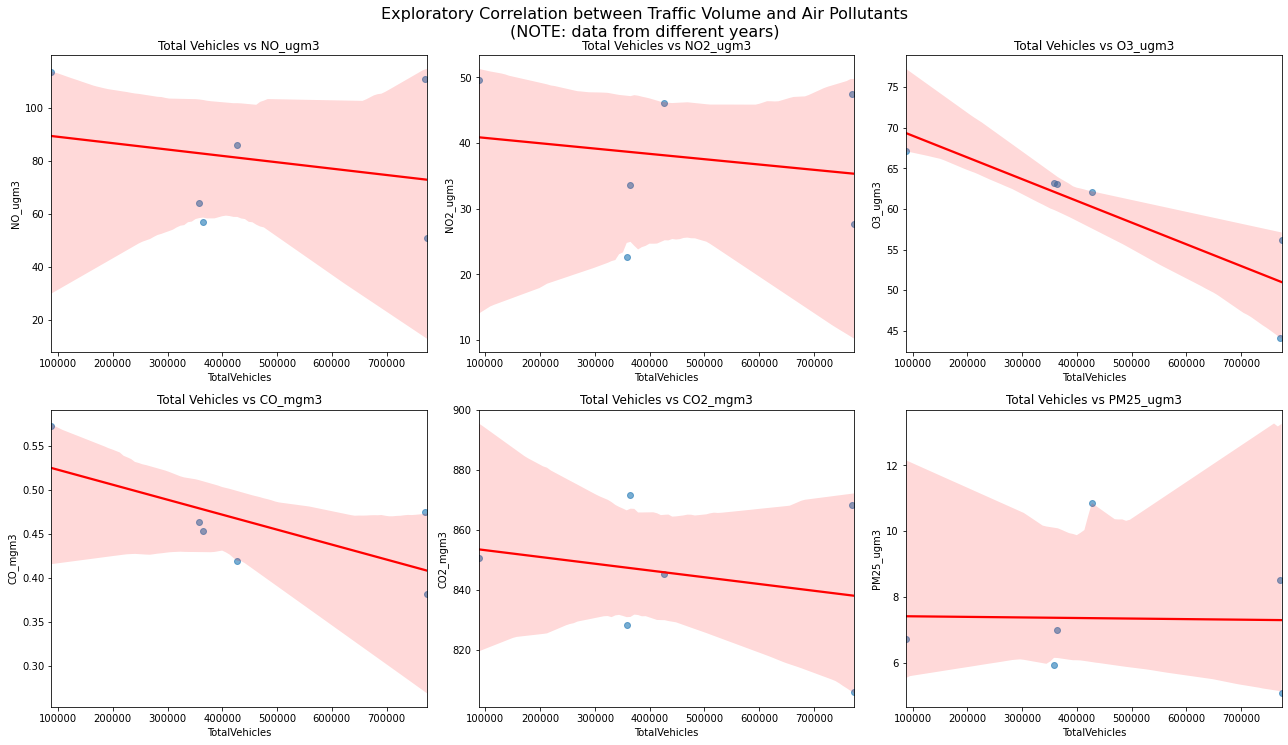

,TotalVehicles,NO_ugm3,NO2_ugm3,O3_ugm3,CO_mgm3,CO2_mgm3,PM25_ugm3
TotalVehicles,1.000000,-0.232546,-0.188978,-0.863648,-0.700906,-0.241079,-0.021995
NO_ugm3,-0.232546,1.000000,0.881691,-0.220030,0.723518,0.500196,0.473044
NO2_ugm3,-0.188978,0.881691,1.000000,-0.163101,0.517748,0.585977,0.670509
O3_ugm3,-0.863648,-0.220030,-0.163101,1.000000,0.289343,-0.148021,-0.149650
CO_mgm3,-0.700906,0.723518,0.517748,0.289343,1.000000,0.474228,-0.028857
CO2_mgm3,-0.241079,0.500196,0.585977,-0.148021,0.474228,1.000000,0.500568
PM25_ugm3,-0.021995,0.473044,0.670509,-0.149650,-0.028857,0.500568,1.000000


In [ ]:
# Scatter plots for each pollutant against TotalVehicles
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for i, pollutant in enumerate(pollutants):
    sns.regplot(
        ax=axes[i],
        data=temp_merged,
        x='TotalVehicles',
        y=pollutant,
        scatter_kws={'alpha': 0.6},
        line_kws={'color': 'red'}
    )
    axes[i].set_title(f'Total Vehicles vs {pollutant}')

plt.tight_layout()
plt.suptitle('Exploratory Correlation between Traffic Volume and Air Pollutants\n(NOTE: data from different years)', y=1.03, fontsize=16)
plt.show()

# Display correlation matrix
display(temp_merged.corr())


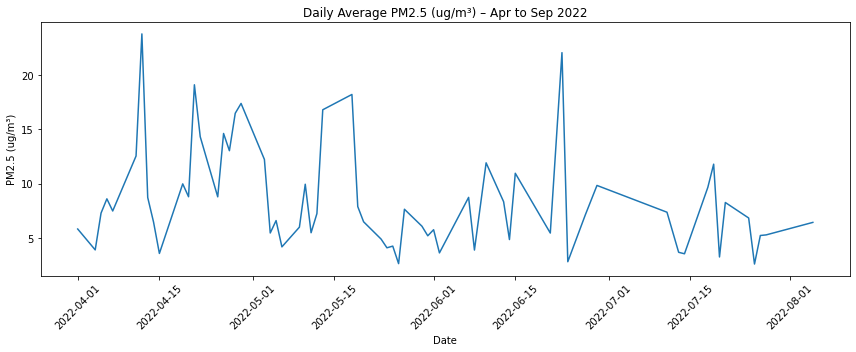

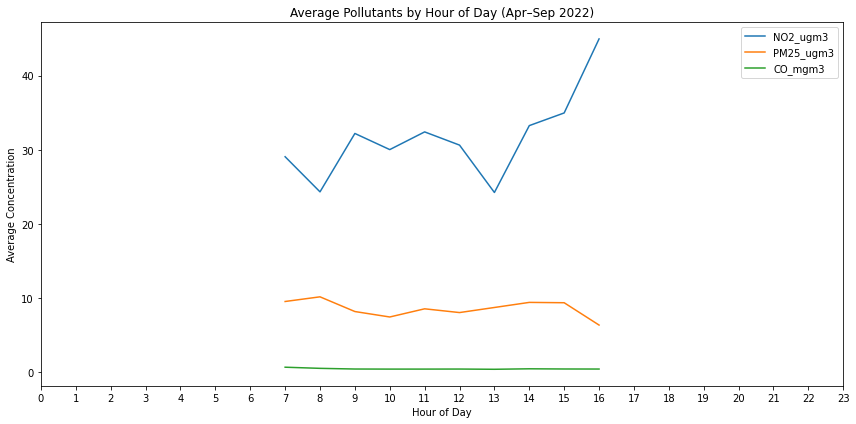

In [ ]:

# ------------------------------------------
# Step 1 – Load full dataset with relevant columns
# ------------------------------------------
pollutant_cols = [
    'gps_timestamp', 'NO_ugm3', 'NO2_ugm3', 'O3_ugm3',
    'CO_mgm3', 'CO2_mgm3', 'PM25_ugm3'
]

# Replace with your file path
csv_path = 'AirView_DublinCity_Measurements_ugm3.csv'

# Load all rows from the dataset
df = pd.read_csv(
    csv_path,
    usecols=pollutant_cols,
    parse_dates=['gps_timestamp'],
    low_memory=False
)

# ------------------------------------------
# Step 2 – Filter by desired date range (April–September 2022)
# ------------------------------------------
df = df[(df['gps_timestamp'].dt.year == 2022) &
        (df['gps_timestamp'].dt.month >= 4) &
        (df['gps_timestamp'].dt.month <= 9)]

# Remove negative values for pollutants
for col in pollutant_cols[1:]:
    df = df[df[col] >= 0]

# Extract date and hour
df['date'] = df['gps_timestamp'].dt.date
df['hour'] = df['gps_timestamp'].dt.hour

# ------------------------------------------
# Step 3 – Daily averages
# ------------------------------------------
daily_avg = df.groupby('date')[pollutant_cols[1:]].mean().reset_index()

# Plot example: daily PM2.5 levels
plt.figure(figsize=(12, 5))
sns.lineplot(data=daily_avg, x='date', y='PM25_ugm3')
plt.title('Daily Average PM2.5 (ug/m³) – Apr to Sep 2022')
plt.xlabel('Date')
plt.ylabel('PM2.5 (ug/m³)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ------------------------------------------
# Step 4 – Hourly averages
# ------------------------------------------
hourly_avg = df.groupby('hour')[pollutant_cols[1:]].mean().reset_index()

# Plot hourly trends for selected pollutants
plt.figure(figsize=(12, 6))
for col in ['NO2_ugm3', 'PM25_ugm3', 'CO_mgm3']:
    sns.lineplot(data=hourly_avg, x='hour', y=col, label=col)

plt.title('Average Pollutants by Hour of Day (Apr–Sep 2022)')
plt.xlabel('Hour of Day')
plt.ylabel('Average Concentration')
plt.xticks(range(0, 24))
plt.legend()
plt.tight_layout()
plt.show()


#### Conclusion – Hypothesis 1: More Cars = Worse Air Quality
Despite the initial hypothesis suggesting that an increased number of vehicles leads to worse air quality, the data analysis does not show a clear or strong correlation between traffic volume and the concentration of air pollutants.

Most scatter plots between TotalVehicles and each pollutant (NO₂, NO, CO₂, CO, O₃, PM2.5) show weak, flat, or even slightly negative trends. Only CO₂ and O₃ display slight upward tendencies, but these are not statistically significant or consistent enough to confirm the hypothesis.

Several factors may explain this:

Temporal mismatch between datasets: traffic data is from November 2019, while air quality data was collected between May 2021 and August 2022;

Spatial aggregation of pollutant data, which may obscure localized effects;

Other pollutant sources (industry, heating systems, etc.) may play a significant role;

Environmental factors such as wind, temperature, and urban ventilation patterns.

Therefore, this analysis should be considered exploratory. It highlights the importance of synchronizing data in time and space when investigating environmental hypotheses.

